In [17]:
import numpy as np
import matplotlib.pyplot as plt

The purpose of this notebook is to investigate the relationship between autoencoders learned using gradient descent and SVD.

Given a matrix $X$, the matrix of rank $k$ minimizing the $L^2$ distance from $X$ is given by projection $X$ onto its first $k$ singular vectors (or principal components).

We can, using pytorch, try to solve the problem

$$\min_{U,V} |X-UV|^2$$

among matrices $U$ and $V$ of inner dimension $k$.

_Question_: which solver is the best for finding the optimum? How stochastic should we expect this to be? To what extent should the minibatch structure matter?

Let's start with some data: 7 features with latent dimension 2, plus noise, for 1000 observations.

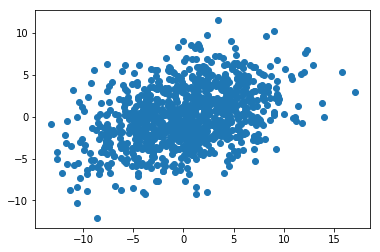

In [27]:
latent_dim = 2
dim = 7
n_obs= 1000

np.random.seed(1)
W = np.random.gamma(2, scale=1, size = (latent_dim, dim))
X_pure = np.dot(np.random.randn(n_obs,latent_dim), W)

noise = np.random.randn(*X_pure.shape)*3
X = X_pure + noise

plt.scatter(X[:,1],X[:,3])

In [28]:
U, s, V = np.linalg.svd(X)

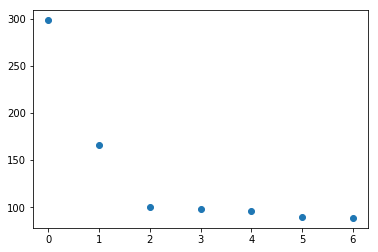

In [29]:
plt.plot(s, 'o')

SVD is the autoencoder with two linear layers, minimizing $L^2$ reconstruction error.

In [21]:
import collections

import torch
import torch.nn as nn
from torch import Tensor
from torch.autograd import Variable
import torch.utils.data as Data

In [22]:
class SVD(nn.Module):
    def __init__(self, n_feat, n_hidden):
        super(SVD, self).__init__()
        self.encoder = nn.Linear(n_feat, n_hidden, bias = False)
        self.decoder = nn.Linear(n_hidden, n_feat, bias = False)
    
    def forward(self, x):
        y = self.decoder(self.encoder(x))
        return y

In [23]:
x = torch.from_numpy(X).float()

In [24]:
def svd(X, k):
    U, s, V = np.linalg.svd(X, full_matrices=False)
    return np.dot(np.dot(U[:,:k], np.diag(s[:k])),V[:k,:])

In [32]:
def torch_svd(X, k):
    model = SVD(X.shape[1], k)
    loss_fn = torch.nn.MSELoss(size_average=False)
    learning_rate = 1e-1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x = torch.from_numpy(X).float()
    for t in range(1000):
      x_pred = model(x)
      loss = loss_fn(x_pred, x)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    return model(x).detach().numpy()

Curiously, the matrices returned by gradient descent using Adam vary from round to round, often with significantly different errors from the optimum.

In [36]:
for k in range(1,6):
    X_svd = svd(X, k)
    torch_svds = [torch_svd(X,k) for i in range(5)]
    diffs = [np.sum(np.square(X_svd - torch_svds[i])) for i in range(5)]
    print("errors in 5 iterations of rank "+ str(k) + " projections: ", [np.round(diff, 4) for diff in diffs])

errors in 5 iterations of rank 1 projections:  [0.0, 0.0, 0.0145, 0.0, 0.0]
errors in 5 iterations of rank 2 projections:  [0.0, 0.0, 4.6923, 0.0, 0.0]
errors in 5 iterations of rank 3 projections:  [0.0, 0.0, 0.0, 0.0, 948.7288]
errors in 5 iterations of rank 4 projections:  [0.0, 0.0, 0.0, 0.0, 0.0]
errors in 5 iterations of rank 5 projections:  [0.0, 1858.365, 0.0008, 0.0, 0.0018]
